In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [4]:
# 读取CSV文件
df = pd.read_csv('../bitcoin_price_sentiment_addmean.csv')

# 确保日期列是datetime格式
df['date'] = pd.to_datetime(df['date'])

# 准备 XGBoost 所需的数据框
#xgboost_df = df[['date', 'Close']].rename(columns={'date': 'ds', 'Close': 'y'})

# prophet_df = df[['date', 'Close', 'sentiment_scores']].rename(columns={'date': 'ds', 'Close': 'y'})

df['lag1'] = df['Close'].shift(1)
df['lag2'] = df['Close'].shift(2)

# 添加其他特征作为回归变量
features = ['Open', 'High', 'Low', 'Volume', 'sentiment_scores', 'lag1', 'lag2']
X = df[features]
y = df['Close']

#features = ['sentiment_scores']

# 标准化特征
# scaler = StandardScaler()
# df[features] = scaler.fit_transform(df[features])

# 将特征添加到prophet_df
# for feature in features:
#     prophet_df[feature] = df[feature]

# 分割数据为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [5]:
import pandas as pd

# 假设你的数据已经加载到一个 DataFrame 中，并且包含 'Close' 列和 'Date' 列
data = pd.read_csv('../bitcoin_price_sentiment_addmean.csv')

# 确保日期列是datetime格式
data['date'] = pd.to_datetime(data['date'])

data['lag1'] = data['Close'].shift(1)
data['lag2'] = data['Close'].shift(2)
data['lag7'] = data['Close'].shift(7)
data['rolling_mean_7'] = data['Close'].rolling(window=7).mean()
data['rolling_std_7'] = data['Close'].rolling(window=7).std()

data = data.dropna()

print(data.head())
# 计算划分点，取前 70% 的数据作为训练集
train_size = int(len(data) * 0.8)

# 使用前 70% 的数据作为训练集，后 30% 的数据作为测试集
train = data[:train_size]
test = data[train_size:]

# 检查训练集和测试集大小
print(f"Training data size: {len(train)}")
print(f"Testing data size: {len(test)}")

# 训练集特征和目标
X_train = train[['Open', 'High', 'Low', 'Volume', 'sentiment_scores', 'lag1', 'lag2', 'lag7', 'rolling_mean_7', 'rolling_std_7']]  # 假设这是你的特征列
y_train = train['Close']  # 收盘价作为目标值

# 测试集特征和目标
X_test = test[['Open', 'High', 'Low', 'Volume', 'sentiment_scores', 'lag1', 'lag2', 'lag7', 'rolling_mean_7', 'rolling_std_7']]
y_test = test['Close']

         date  Open  High   Low  Close  Volume  sentiment_scores  lag1  lag2  \
7  2012-01-08  6.90  6.90  6.90   6.90     0.0          0.201493  6.80  6.40   
8  2012-01-09  6.48  6.48  6.48   6.48     0.0          0.201493  6.90  6.80   
9  2012-01-10  7.10  7.10  7.10   7.10     0.0          0.201493  6.48  6.90   
10 2012-01-11  7.00  7.00  7.00   7.00     0.0          0.201493  7.10  6.48   
11 2012-01-12  6.51  6.51  6.51   6.51     0.0          0.201493  7.00  7.10   

    lag7  rolling_mean_7  rolling_std_7  
7   4.84        6.054286       0.758812  
8   5.00        6.265714       0.607120  
9   5.29        6.524286       0.497924  
10  5.57        6.728571       0.291858  
11  6.42        6.741429       0.277635  
Training data size: 3722
Testing data size: 931


In [6]:
# 转换为 DMatrix 格式
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [7]:
# 设置 XGBoost 参数
params = {
    'booster': 'gbtree', # Tree model, suitable for most scenarios
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.01, # 学习率。值越小，模型收敛越慢，但可以提高泛化能力。典型值为 0.01 到 0.3。
    'max_depth': 6,                   # 决策树的最大深度, 控制树的复杂度。较大的值会增加模型的复杂度，容易过拟合；较小的值会导致欠拟合。
    'min_child_weight': 9, # 决定最小叶节点样本权重的和。较大的值会使模型更保守，防止过拟合。推荐值 1 - 10
    'gamma': 0.1, # 分裂节点时的最小损失减少量，控制模型的复杂度。值越大，模型越保守。推荐值 0 - 5
    'subsample': 0.8,                 # 每棵树随机采样的比例，防止过拟合。典型值为 0.5 到 1
    'colsample_bytree': 0.8,           # 每棵树的特征随机采样比例
    'lambda': 20,  # L2 正则化项的权重，较大的值会使模型更加保守。默认值为 1。
    'alpha': 5,  # L1 正则化项的权重，增加稀疏性，有助于特征选择。默认值为 0。
    'eval_metric': 'mae'  # 使用 MAE 作为评估指标
}

num_round = 2000  # 训练轮次

In [8]:
import time

# 训练模型
training_start_time = time.time()
bst = xgb.train(params, dtrain, num_boost_round=num_round)
training_end_time = time.time()
training_time = training_end_time - training_start_time
print(f"Training time: {training_time:.2f} seconds")

Training time: 3.89 seconds


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# 对测试集进行预测
testing_start_time = time.time()
y_pred = bst.predict(dtest)
testing_end_time = time.time()
testing_time = testing_end_time - testing_start_time
print(f"Testing time: {testing_time:.2f} seconds")

# 计算均方误差 (MSE)
#mse = mean_squared_error(y_test, y_pred)
#print(f"Mean Squared Error (MSE): {mse}")

# MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

Testing time: 0.00 seconds
Mean Absolute Error (MAE): 1246.7705366373523
Mean Absolute Percentage Error (MAPE): 3.760038180906204


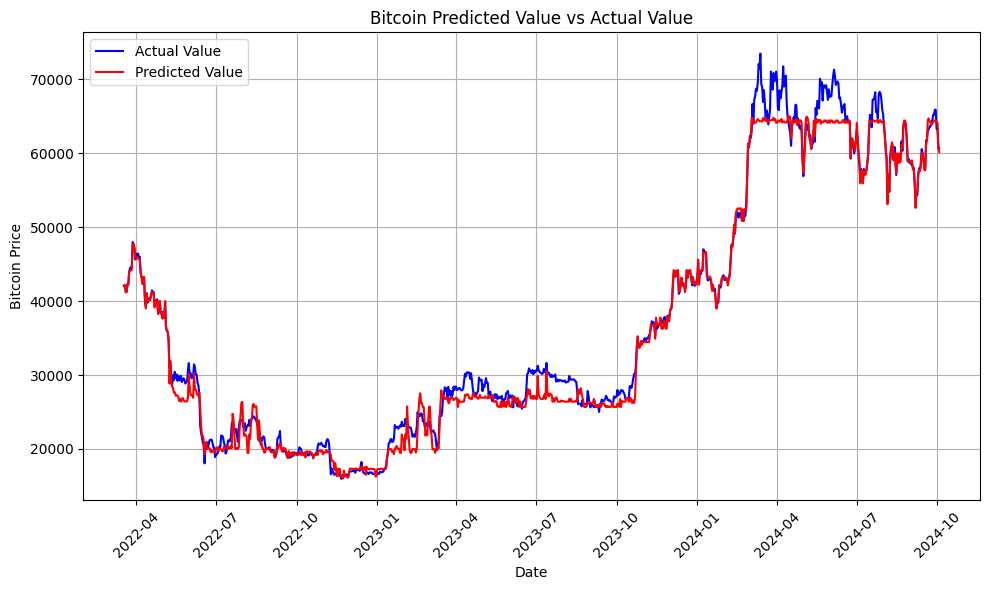

Last Date: 2024-10-03 00:00:00


In [10]:
# 可视化实际值和预测值
plt.figure(figsize=(10, 6))
# 绘制真实值
plt.plot(test['date'], y_test, label='Actual Value', color='blue')

# 绘制预测值
plt.plot(test['date'], y_pred, label='Predicted Value', color='red')

# 设置 x 轴为日期
plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.title('Bitcoin Predicted Value vs Actual Value')

plt.grid(True)

# 显示图例
plt.legend()

# 显示图表
plt.xticks(rotation=45)  # 旋转日期标签，避免重叠
plt.tight_layout()
plt.show()

last_date = test['date'].max()
print("Last Date:", last_date)

In [ ]:
import joblib

joblib.dump(bst, 'xgboost_model.pkl')

### Crypto Compare API Bitcoin Data

In [11]:
import sys
print(sys.executable)

/opt/anaconda3/envs/api_test/bin/python


In [17]:
import requests

def get_crypto_compare_data(start_date, end_date, api_key):
    url = 'https://min-api.cryptocompare.com/data/v2/histoday'
    params = {
        'fsym': 'BTC',
        'tsym': 'USD',
        'limit': 30,  # Set the maximum number of days to retrieve
        'toTs': end_date,
        'api_key': api_key  # Your API key
    }
    response = requests.get(url, params=params)
    data = response.json()

    if 'Data' in data and 'Data' in data['Data']:
        return pd.DataFrame(data['Data']['Data'])
    else:
        print("Error fetching data:", data)
        return None
    
# Assuming you have obtained the API key and set the start and end dates
api_key = 'your_api_key'
start_date = int(pd.Timestamp('2024-10-25').timestamp())
end_date = int(pd.Timestamp('2024-11-21').timestamp())

# Fetch historical price data
btc_data = get_crypto_compare_data(start_date, end_date, api_key)
from datetime import datetime as dt

# 将时间戳列转换为datetime格式，无法解析的时间戳将变为NaT
btc_data['bit_coin_date_time'] = pd.to_datetime(btc_data['time'], unit='s', errors='coerce')
# btc_data.to_csv('bitcoin_date_time_price.csv', index=False)
# 删除包含非法时间戳（NaT）的行
btc_data = btc_data.dropna(subset=['bit_coin_date_time'])
btc_data = btc_data.groupby(btc_data['bit_coin_date_time'].dt.date).tail(1)
btc_data['date'] = btc_data['bit_coin_date_time'].dt.strftime('%Y-%m-%d')
# btc_data = btc_data[['date', 'Open', 'High', 'Low', 'Close', 'Volume']]
print(btc_data.head())

         time      high       low      open  volumefrom      volumeto  \
0  1729555200  67800.62  66540.70  67358.14    32484.74  2.184453e+09   
1  1729641600  67436.29  65171.54  67390.32    32488.79  2.154644e+09   
2  1729728000  68812.40  66456.70  66612.97    31715.51  2.144280e+09   
3  1729814400  68745.57  65510.53  68163.56    43824.41  2.952725e+09   
4  1729900800  67366.46  66343.25  66577.77    14159.11  9.464474e+08   

      close conversionType conversionSymbol bit_coin_date_time        date  
0  67390.32         direct                          2024-10-22  2024-10-22  
1  66612.97         direct                          2024-10-23  2024-10-23  
2  68163.56         direct                          2024-10-24  2024-10-24  
3  66577.77         direct                          2024-10-25  2024-10-25  
4  67014.72         direct                          2024-10-26  2024-10-26  


In [13]:
# 创建一个空列表保存预测结果
future_predictions = []
last_row = test.max()
print(last_row)

# 复制最后一行数据，作为递归预测的初始状态
next_input = last_row.copy()
feature_names = ['Open', 'High', 'Low', 'Volume', 'sentiment_scores', 'lag1', 'lag2', 'lag7', 'rolling_mean_7', 'rolling_std_7']

for _ in range(31):
    # 取当前特征的值
    input_data = np.array([next_input['Open'], next_input['High'], next_input['Low'],
                           next_input['Volume'], next_input['sentiment_scores'], next_input['lag1'], next_input['lag2'], next_input['lag7'],
                           next_input['rolling_mean_7'], next_input['rolling_std_7']]).reshape(1, -1)
    
    # 转换为 DMatrix 格式
    dmatrix = xgb.DMatrix(input_data, feature_names=feature_names)

    # 使用模型预测下一天的价格
    next_pred = bst.predict(dmatrix)[0]
    
    # 将预测结果添加到 future_predictions 列表
    future_predictions.append(next_pred)
    
    # 更新特征
    next_input['lag1'] = next_pred  # 将预测值作为新的 lag1
    next_input['lag7'] = next_input['lag1']  # 更新 lag7（往前推7天可以依次更新）
    
    # 更新滚动特征
    rolling_values = [next_input['lag1'], next_input['lag7'], *future_predictions[-6:]]
    next_input['rolling_mean_7'] = np.mean(rolling_values)
    next_input['rolling_std_7'] = np.std(rolling_values)

# 将未来 30 天的预测值转为 DataFrame，包含日期
future_dates = pd.date_range(start=last_row['date'], periods=31, freq='D')
future_df = pd.DataFrame({'Date': future_dates, 'Predicted_Price': future_predictions})

date                2024-10-03 00:00:00
Open                            73297.0
High                            73508.0
Low                             73297.0
Close                           73468.0
Volume                       146.055446
sentiment_scores               0.318447
lag1                            73468.0
lag2                            73468.0
lag7                            73468.0
rolling_mean_7             70463.285714
rolling_std_7               4689.409537
dtype: object


In [28]:
# 创建一个空列表保存预测结果
future_predictions = []
last_row = test.max()
print(last_row)

# 复制最后一行数据，作为递归预测的初始状态
next_input = last_row.copy()
feature_names = ['Open', 'High', 'Low', 'Volume', 'sentiment_scores', 'lag1', 'lag2', 'lag7', 'rolling_mean_7', 'rolling_std_7']

start_date = '2024-10-25'
end_date = '2024-11-21'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
print("length: ", (date_range))

for _ in range(len(date_range)):
    # 取当前特征的值
    input_data = np.array([next_input['Open'], next_input['High'], next_input['Low'],
                           next_input['Volume'], next_input['sentiment_scores'], next_input['lag1'], next_input['lag2'], next_input['lag7'],
                           next_input['rolling_mean_7'], next_input['rolling_std_7']]).reshape(1, -1)
    
    # 转换为 DMatrix 格式
    dmatrix = xgb.DMatrix(input_data, feature_names=feature_names)

    # 使用模型预测下一天的价格
    next_pred = bst.predict(dmatrix)[0]
    
    # 将预测结果添加到 future_predictions 列表
    future_predictions.append(next_pred)
    
    # 更新特征
    next_input['lag1'] = next_pred  # 将预测值作为新的 lag1
    next_input['lag7'] = next_input['lag1']  # 更新 lag7（往前推7天可以依次更新）
    
    # 更新滚动特征
    rolling_values = [next_input['lag1'], next_input['lag7'], *future_predictions[-6:]]
    next_input['rolling_mean_7'] = np.mean(rolling_values)
    next_input['rolling_std_7'] = np.std(rolling_values)

print(future_predictions)
# 将未来 30 天的预测值转为 DataFrame，包含日期
future_dates = date_range
future_df = pd.DataFrame({'Date': future_dates, 'Predicted_Price': future_predictions})

date                2024-10-03 00:00:00
Open                            73297.0
High                            73508.0
Low                             73297.0
Close                           73468.0
Volume                       146.055446
sentiment_scores               0.318447
lag1                            73468.0
lag2                            73468.0
lag7                            73468.0
rolling_mean_7             70463.285714
rolling_std_7               4689.409537
dtype: object
length:  DatetimeIndex(['2024-10-25', '2024-10-26', '2024-10-27', '2024-10-28',
               '2024-10-29', '2024-10-30', '2024-10-31', '2024-11-01',
               '2024-11-02', '2024-11-03', '2024-11-04', '2024-11-05',
               '2024-11-06', '2024-11-07', '2024-11-08', '2024-11-09',
               '2024-11-10', '2024-11-11', '2024-11-12', '2024-11-13',
               '2024-11-14', '2024-11-15', '2024-11-16', '2024-11-17',
               '2024-11-18', '2024-11-19', '2024-11-20', '2024-11-21'],

2024-11-21 00:00:00
          time      high       low      open  volumefrom      volumeto  \
3   1729814400  68745.57  65510.53  68163.56    43824.41  2.952725e+09   
4   1729900800  67366.46  66343.25  66577.77    14159.11  9.464474e+08   
5   1729987200  68254.55  66852.50  67014.72    12105.31  8.185810e+08   
6   1730073600  70241.74  67541.00  67945.14    42091.94  2.902994e+09   
7   1730160000  73612.24  69725.05  69925.83    58289.36  4.194343e+09   
8   1730246400  72945.06  71408.40  72723.67    38392.15  2.769523e+09   
9   1730332800  72675.24  69585.02  72331.96    39358.14  2.794857e+09   
10  1730419200  71616.01  68755.75  70207.54    49030.12  3.429442e+09   
11  1730505600  69884.38  69006.88  69473.41    10811.20  7.507333e+08   
12  1730592000  69364.80  67457.91  69354.01    29674.18  2.028671e+09   
13  1730678400  69453.56  66793.64  68747.04    43141.35  2.939057e+09   
14  1730764800  70540.03  67432.99  67811.95    47211.37  3.274520e+09   
15  1730851200  76

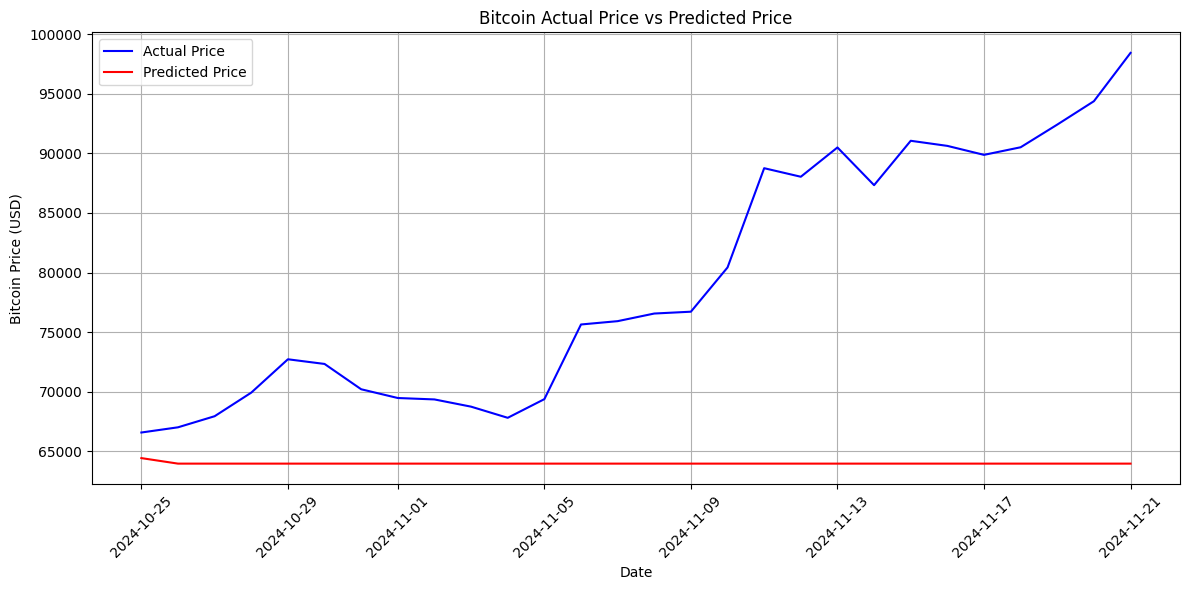

In [32]:
# 绘制对比图表
plt.figure(figsize=(12, 6))
print(future_df['Date'].max())

# 将日期列转换为 datetime 格式
btc_data['date'] = pd.to_datetime(btc_data['date'], errors='coerce')
btc_data = btc_data[btc_data['date'] >= start_date]

future_df['Date'] = pd.to_datetime(future_df['Date'], errors='coerce')

print(btc_data)

# 绘制实际价格
plt.plot(btc_data['date'], btc_data['close'], label='Actual Price', color='blue')

# 绘制预测价格
plt.plot(future_df['Date'], future_df['Predicted_Price'], label='Predicted Price', color='red')
plt.grid(True)
# 添加图表标签和标题
plt.xlabel('Date')
plt.ylabel('Bitcoin Price (USD)')
plt.title('Bitcoin Actual Price vs Predicted Price')
plt.legend()

# 显示图表
plt.xticks(rotation=45)  # 旋转日期标签，避免重叠
plt.tight_layout()
plt.show()

In [33]:
# 计算 MAE
mae = mean_absolute_error(btc_data['close'].values, future_df['Predicted_Price'].values)
print("Mean Absolute Error (MAE) on api bitcoin data:", mae)

# 计算 MAPE
mape = np.mean(np.abs((btc_data['close'].values - future_df['Predicted_Price'].values) / btc_data['close'].values)) * 100
print("Mean Absolute Percentage Error (MAPE) on api bitcoin data:", mape, "%")

Mean Absolute Error (MAE) on api bitcoin data: 15256.365005580356
Mean Absolute Percentage Error (MAPE) on api bitcoin data: 17.935422670476544 %
